# Few-Shot Experiments on Multiverse Math

This notebook walks through how to run few-shot experiments on the multiverse math dataset, which you can find [here](https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/b9b6d6e9-1b80-4d6d-8344-fc1de3a269c8). 

## Setup

First, let's set up our notebook by collecting the correct imports

In [1]:
import datetime
import uuid

from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.messages.utils import convert_to_messages
from langsmith.client import Client
from langsmith.evaluation import evaluate

from langchain_benchmarks import __version__, registry
from langchain_benchmarks.tool_usage.tasks.multiverse_math import *

# Define our LangSmith client so we have access to it throughout the rest of the notebook
client = Client()

## List tests

Next, we can list the models that we will be running experiments over. Due to the new universal configurable model, this is easier than ever. All we need to do is save a list of model names and providers, like so:

In [7]:
models = [
    (
        "claude-3-haiku-20240307",
        "anthropic",
    ),
    (
        "claude-3-sonnet-20240229",
        "anthropic",
    ),
    (
        "claude-3-opus-20240229",
        "anthropic",
    ),
    (
        "claude-3-5-sonnet-20240620",
        "anthropic",
    ),
    ("gpt-3.5-turbo-0125", "openai"),
    (
        "gpt-4o",
        "openai",
    ),
    ("gpt-4o-mini", "openai"),
]

Feel free to add/remove any models that you personally want to test.

IMPORTANT: Make sure you have installed the correct packages (i.e `langchain_openai` if using "openai" provided models) and set the correct environment keys (i.e `OPENAI_API_KEY` if using "opneai" provided models). If you do not do so - the code will not work!

## Defining Helper Functions

### Extracting few-shot examples from our dataset

First, we need to define a function that takes the examples from the dataset `multiverse-math-examples-for-few-shot` and turns them into something we can use for our model. In our example we are going to compare how passing in all 9 few-shot examples differs from just passing in the first 3. 

In [8]:
def get_few_shot_messages():
    uncleaned_examples = [
        e
        for e in client.list_examples(
            dataset_name="multiverse-math-examples-for-few-shot"
        )
    ]
    few_shot_messages = []
    few_shot_first_three_messages = []
    examples = []
    for i in range(len(uncleaned_examples)):
        converted_messages = convert_to_messages(
            uncleaned_examples[i].outputs["output"]
        )
        examples.append(
            # The message at index 1 is the human message asking the actual math question (0th message is system prompt)
            {
                "question": converted_messages[1].content,
                "messages": [
                    m
                    for m in converted_messages
                    # The system prompt should only appear once at the beginning, so we remove it from few-shot examples
                    if isinstance(m, SystemMessage) == False
                ],
            }
        )
        few_shot_messages += converted_messages
        if i < 3:
            few_shot_first_three_messages += converted_messages

    return (
        examples,
        [m for m in few_shot_messages if not isinstance(m, SystemMessage)],
        [m for m in few_shot_first_three_messages if not isinstance(m, SystemMessage)],
    )

In this experiment we are also comparing passing in the few-shot examples as strings instead of passing them in as a list of messages, so we define a few more helper functions to allow us to do this:

In [9]:
def turn_messages_to_str(few_shot_messages):
    few_shot_str = ""
    for m in few_shot_messages:
        if isinstance(m.content, list):
            few_shot_str += "<|im_start|>assistant"
            for tool_use in m.content:
                if "name" in tool_use:
                    few_shot_str += f"Use tool {tool_use['name']}, input: {', '.join(f'{k}:{v}' for k,v in tool_use['input'].items())}"
                else:
                    few_shot_str += tool_use["text"]
                few_shot_str += "\n"
            few_shot_str += "\n<|im_end|>"
        else:
            if isinstance(m, HumanMessage):
                few_shot_str += f"<|im_start|>user\n{m.content}\n<|im_end|>"
            elif isinstance(m, ToolMessage):
                few_shot_str += f"<|im_start|>tool\n{m.content}\n<|im_end|>"
            else:
                few_shot_str += f"<|im_start|>assistant\n{m.content}\n<|im_end|>"

        few_shot_str += "\n"
    return few_shot_str


def get_few_shot_str_from_messages(few_shot_messages, few_shot_first_three_messages):
    few_shot_str = turn_messages_to_str(few_shot_messages)
    few_shot_first_three_str = turn_messages_to_str(few_shot_first_three_messages)
    return few_shot_str, few_shot_first_three_str

Lastly, we will define a function to return the different few-shot prompts we are going to use:

In [10]:
def get_prompts():
    return [
        (
            client.pull_prompt("langchain-ai/multiverse-math-no-few-shot"),
            "no-few-shot",
        ),
        (
            client.pull_prompt("langchain-ai/multiverse-math-few-shot-messages"),
            "few-shot-messages",
        ),
        (
            client.pull_prompt("langchain-ai/multiverse-math-few-shot-str"),
            "few-shot-string",
        ),
        (
            client.pull_prompt("langchain-ai/multiverse-math-few-shot-3-messages"),
            "few-shot-three-messages",
        ),
        (
            client.pull_prompt("langchain-ai/multiverse-math-few-shot-3-str"),
            "few-shot-three-strings",
        ),
    ]

Now we are ready to actually run our experiment!

## Running Experiment

To run our experiment, we can iterate over our models and prompts and use the `evaluate` function to send our results to LangSmith.

In [3]:
def predict_from_callable(callable, instructions):
    def predict(run):
        return callable.invoke(
            {"question": run["question"], "instructions": instructions}
        )

    return predict


experiment_uuid = uuid.uuid4().hex[:4]
today = datetime.date.today().isoformat()
task = MULTIVERSE_MATH
dataset_name = task.name
examples, few_shot_messages, few_shot_three_messages = get_few_shot_messages()
few_shot_str, few_shot_three_str = get_few_shot_str_from_messages(
    few_shot_messages, few_shot_three_messages
)
prompts = get_prompts()

for model_name, model_provider in models:
    model = init_chat_model(model_name, model_provider=model_provider, temperature=0)

    print(f"Benchmarking {task.name} with model: {model_name}")
    eval_config = task.get_eval_config()

    for prompt, prompt_name in prompts[:-1]:
        tools = task.create_environment().tools
        agent = create_tool_calling_agent(model, tools, prompt)
        agent_executor = AgentExecutor(
            agent=agent, tools=tools, return_intermediate_steps=True
        )

        evaluate(
            predict_from_callable(agent_executor, task.instructions),
            data=dataset_name,
            evaluators=eval_config.custom_evaluators,
            max_concurrency=5,
            metadata={
                "model": model_name,
                "id": experiment_uuid,
                "task": task.name,
                "date": today,
                "langchain_benchmarks_version": __version__,
            },
            experiment_prefix=f"{model_name}-{task.name}-{prompt_name}",
        )

## Visualize Results

Now that we have run the evaluation, we can visualize our results.

In [26]:
projects = [
    p
    for p in client.list_projects(reference_dataset_name="Multiverse Math")
    if p.metadata["id"] == experiment_uuid
]

In [28]:
models = set([p.name.split("-Multiverse")[0] for p in projects])
few_shot_type = set([p.name.split("Math-")[1] for p in projects])
few_shot_type = set([t[: t.rfind("-")] for t in few_shot_type])

In [ ]:
results_dic = {}
for model in models:
    model_results = []
    for few_shot in few_shot_type:
        experiment = [
            p
            for p in projects
            if model + "-Multiverse" in p.name and few_shot in p.name
        ][0]
        experiment_stats = client.get_run_stats(
            project_ids=[experiment.id], is_root=True
        )
        model_results.append(
            100
            * experiment_stats["feedback_stats"]["correctness"]["avg"]
            * (1 - experiment_stats["error_rate"])
        )
    results_dic[model] = model_results

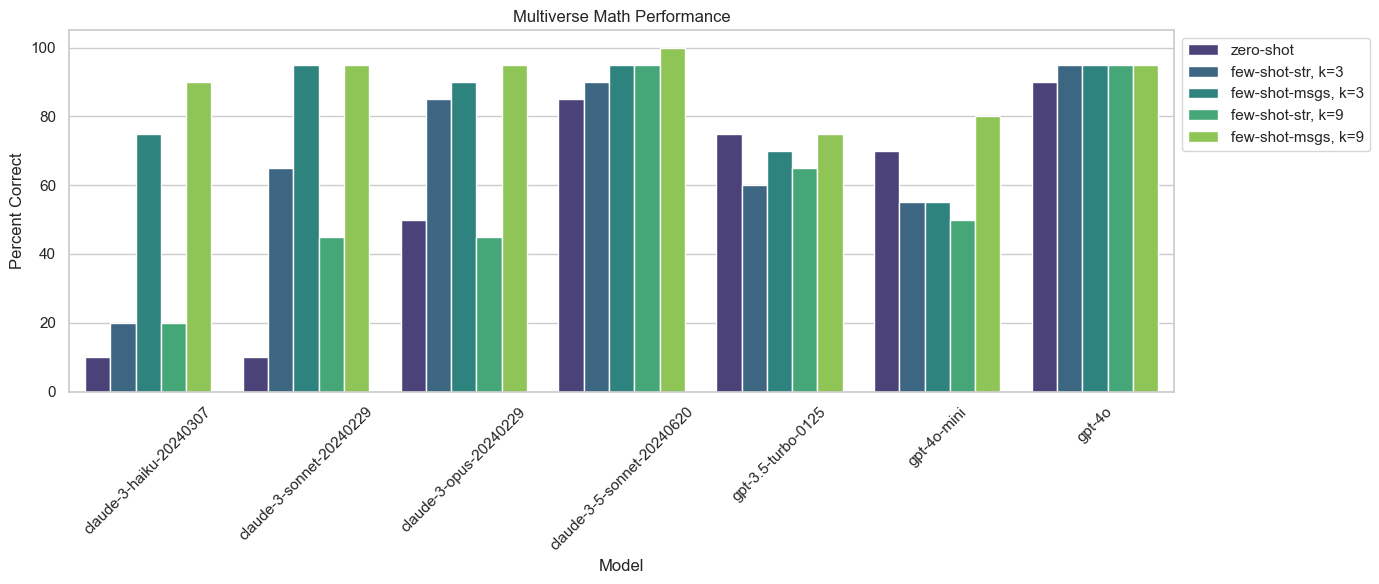

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

results = np.array([results_dic[model] for model in models])

# Create a DataFrame for Seaborn plotting
df = pd.DataFrame(results.T, columns=list(models))
df["Few Shot Type"] = list(few_shot_type)
df.iloc[[0, 1, 2, 3, 4]] = df.iloc[[3, 4, 0, 2, 1]].to_numpy()
df = df[df.columns[[3, 2, 0, 5, 6, 4, 1, 7]]]

# Melt the DataFrame to long format for Seaborn's barplot
df_melted = df.melt(
    id_vars="Few Shot Type", var_name="Model", value_name="Percent Correct"
)

# Set up Seaborn parameters
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")

# Plot using Seaborn
sns.barplot(
    x="Model",
    y="Percent Correct",
    hue="Few Shot Type",
    data=df_melted,
    palette="viridis",
)

# Add labels and title
plt.xlabel("Model")
plt.ylabel("Percent Correct")
plt.title("Multiverse Math Performance")
plt.xticks(rotation=45)
plt.tight_layout()

legend_labels = {
    "no-few-shot": "zero-shot",
    "few-shot-messages": "few-shot-msgs, k=9",
    "few-shot-string": "few-shot-str, k=9",
    "few-shot-three-messages": "few-shot-msgs, k=3",
    "few-shot-three-strings": "few-shot-str, k=3",
}
# Get the current handles and labels from the plot
handles, labels = plt.gca().get_legend_handles_labels()
labels = [legend_labels.get(label, label) for label in labels]

# Update the legend with the new labels
plt.legend(handles, labels, loc="upper left", bbox_to_anchor=(1, 1))
plt.show()